# Environment

In [2]:
import pandas as pd
import numpy as np
import ddfloww as dd
import scipy as sp
import scipy.stats as stats
import xgboost as xgb
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split



# Acquisition

Created four dataframes of properties and predictions (2016 & 2017). Joined them into a single dataframe which was exported to a csv file in order to facilitate working locally on a single machine. The previous operations ran once and then commented out. The function below reads in the saved `zillow.csv` file.

In [3]:
df = dd.get_zillow()

# Preparation

In [4]:
# Plot styling
plt.style.use('fivethirtyeight')

Let's take a peek at the dataframe and summarize.

In [5]:
dd.summarize_data(df)
df.shape

HEAD
   parcelid  logerror transactiondate       id  airconditioningtypeid  \
0  11016594    0.0276      2016-01-01  2931667                    1.0   
1  14366692   -0.1684      2016-01-01   475764                    NaN   
2  12098116   -0.0040      2016-01-01  2444575                    1.0   
3  12643413    0.0218      2016-01-02  1584730                    1.0   
4  14432541   -0.0050      2016-01-02  2926916                    NaN   

   architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
0                       NaN           NaN          2.0         3.0   
1                       NaN           NaN          3.5         4.0   
2                       NaN           NaN          3.0         2.0   
3                       NaN           NaN          2.0         2.0   
4                       NaN           NaN          2.5         4.0   

   buildingclasstypeid         ...           taxdelinquencyflag  \
0                  NaN         ...                          NaN   
1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 68 columns):
parcelid                        167888 non-null int64
logerror                        167888 non-null float64
transactiondate                 167888 non-null object
id                              167888 non-null int64
airconditioningtypeid           53788 non-null float64
architecturalstyletypeid        468 non-null float64
basementsqft                    93 non-null float64
bathroomcnt                     167854 non-null float64
bedroomcnt                      167854 non-null float64
buildingclasstypeid             31 non-null float64
buildingqualitytypeid           107173 non-null float64
calculatedbathnbr               166056 non-null float64
decktypeid                      1272 non-null float64
finishedfloor1squarefeet        12893 non-null float64
calculatedfinishedsquarefeet    166992 non-null float64
finishedsquarefeet12            159519 non-null float64
finishedsquar

calculatedfinishedsquarefeet:
(-33.638999999999996, 3565.8]    159086
(3565.8, 7129.6]                   7523
(7129.6, 10693.4]                   337
(10693.4, 14257.2]                   30
(14257.2, 17821.0]                    8
(17821.0, 21384.8]                    5
(21384.8, 24948.6]                    2
(24948.6, 28512.4]                    0
(28512.4, 32076.2]                    0
(32076.2, 35640.0]                    1
Name: calculatedfinishedsquarefeet, dtype: int64


finishedsquarefeet12:
(-19.928, 2194.7]     125263
(2194.7, 4387.4]       31355
(4387.4, 6580.1]        2369
(6580.1, 8772.8]         402
(8772.8, 10965.5]         89
(10965.5, 13158.2]        24
(13158.2, 15350.9]         8
(15350.9, 17543.6]         4
(17543.6, 19736.3]         2
(19736.3, 21929.0]         3
Name: finishedsquarefeet12, dtype: int64


finishedsquarefeet13:
(1055.471, 1108.8]     3
(1108.8, 1161.6]       3
(1161.6, 1214.4]       1
(1214.4, 1267.2]       5
(1267.2, 1320.0]       1
(1320.0, 1372.8] 

(10.645000000000001, 147.4]    79
(147.4, 282.8]                 35
(282.8, 418.2]                 19
(418.2, 553.6]                 11
(553.6, 689.0]                  6
(689.0, 824.4]                  1
(824.4, 959.8]                  4
(959.8, 1095.2]                 3
(1095.2, 1230.6]                5
(1230.6, 1366.0]                2
Name: yardbuildingsqft26, dtype: int64


yearbuilt:
(1823.807, 1843.2]        1
(1843.2, 1862.4]          0
(1862.4, 1881.6]          3
(1881.6, 1900.8]        183
(1900.8, 1920.0]       3772
(1920.0, 1939.2]      14536
(1939.2, 1958.4]      40250
(1958.4, 1977.6]      43705
(1977.6, 1996.8]      41424
(1996.8, 2016.0]      22954
Name: yearbuilt, dtype: int64


numberofstories:
NaN     129719
 1.0     22413
 2.0     14808
 3.0       945
 4.0         2
 6.0         1
Name: numberofstories, dtype: int64


fireplaceflag:
NaN     167494
 1.0       394
Name: fireplaceflag, dtype: int64


structuretaxvaluedollarcnt:
(-11377.747, 1142218.6]     166173
(114221

(167888, 68)

Aggressively reduce number of column variables:

1. Columns and (subsequently) rows were removed if their number of missing values exceeds the threshold of 50% for columns and 75% for rows.
1. Columns that are redundant or add no value were also removed.
1. Certain rows were removed if the given columns' values are null.
1. Estimated single-unit dwellings were estimated and filtered in.

In [6]:
df = dd.prep_zillow(df,
                    preq_col=.5,
                    preq_row=.6,
                    cols_to_remove=['parcelid',
                                    'id',
                                    'finishedsquarefeet12',
                                    'fips',
                                    'heatingorsystemtypeid',
                                    'propertylandusetypeid',
                                    'rawcensustractandblock',
                                    'regionidcity',
                                    'roomcnt',
                                    'assessmentyear',
                                    'censustractandblock',
                                    'structuretaxvaluedollarcnt',
                                    'taxvaluedollarcnt',
                                    'propertycountylandusecode',
                                    'propertycountylandusecode',
                                    'propertylandusetypeid',
                                    'propertyzoningdesc',],
                    cols_to_validate=['latitude', 'longitude'])

Impute the values in land square feet using linear regression with landtaxvaluedollarcnt as x and estimated land square feet as y.

In [7]:
df = dd.impute_missing(df)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[32683.87758287]
[[-0.01046837]]
Univariate - final_exam = b + m * exam1
    y-intercept (b): 32683.88
    coefficient (m): -0.01



In [8]:
dd.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
logerror,0,0.000000,0,0.0,0,0.0
transactiondate,0,0.000000,0,0.0,0,0.0
bathroomcnt,0,0.000000,0,0.0,0,0.0
bedroomcnt,0,0.000000,0,0.0,0,0.0
buildingqualitytypeid,56590,34.809620,0,0.0,0,0.0
calculatedbathnbr,112,0.068893,0,0.0,0,0.0
calculatedfinishedsquarefeet,26,0.015993,0,0.0,0,0.0
fullbathcnt,112,0.068893,0,0.0,0,0.0
latitude,0,0.000000,0,0.0,0,0.0
longitude,0,0.000000,0,0.0,0,0.0


In [9]:
df = dd.fill_with_median(df, ['buildingqualitytypeid', 'unitcnt', 'yearbuilt'])

In [10]:
df = dd.fill_with_none(df, 'heatingorsystemdesc')

In [11]:
dd.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
logerror,0,0.000000,0,0.0,0,0.0
transactiondate,0,0.000000,0,0.0,0,0.0
bathroomcnt,0,0.000000,0,0.0,0,0.0
bedroomcnt,0,0.000000,0,0.0,0,0.0
buildingqualitytypeid,0,0.000000,0,0.0,0,0.0
calculatedbathnbr,112,0.068893,0,0.0,0,0.0
calculatedfinishedsquarefeet,26,0.015993,0,0.0,0,0.0
fullbathcnt,112,0.068893,0,0.0,0,0.0
latitude,0,0.000000,0,0.0,0,0.0
longitude,0,0.000000,0,0.0,0,0.0


In [12]:
dd.missing_values_row(df)

,num_missing,percentage
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


Let's check data types.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162570 entries, 0 to 167887
Data columns (total 19 columns):
logerror                        162570 non-null float64
transactiondate                 162570 non-null object
bathroomcnt                     162570 non-null float64
bedroomcnt                      162570 non-null float64
buildingqualitytypeid           162570 non-null float64
calculatedbathnbr               162458 non-null float64
calculatedfinishedsquarefeet    162544 non-null float64
fullbathcnt                     162458 non-null float64
latitude                        162570 non-null float64
longitude                       162570 non-null float64
lotsizesquarefeet               162570 non-null float64
regionidcounty                  162570 non-null float64
regionidzip                     162512 non-null float64
unitcnt                         162570 non-null float64
yearbuilt                       162570 non-null float64
landtaxvaluedollarcnt           162568 non-null fl

Convert column variables into their proper data type.

In [14]:
df = dd.convert_to_string(df,
                          'buildingqualitytypeid',
                          'regionidcounty',
                          'regionidzip',)

In [15]:
df = dd.convert_to_int(df, 'yearbuilt')

Check colummn variables for the correct data type after `astype()` conversions.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162570 entries, 0 to 167887
Data columns (total 19 columns):
logerror                        162570 non-null float64
transactiondate                 162570 non-null object
bathroomcnt                     162570 non-null float64
bedroomcnt                      162570 non-null float64
buildingqualitytypeid           162570 non-null object
calculatedbathnbr               162458 non-null float64
calculatedfinishedsquarefeet    162544 non-null float64
fullbathcnt                     162458 non-null float64
latitude                        162570 non-null float64
longitude                       162570 non-null float64
lotsizesquarefeet               162570 non-null float64
regionidcounty                  162570 non-null object
regionidzip                     162570 non-null object
unitcnt                         162570 non-null float64
yearbuilt                       162570 non-null int64
landtaxvaluedollarcnt           162568 non-null float64

Now, let's check for some outliers.

In [17]:
# dd.plot_subs(df,
#              df.select_dtypes(include='number').columns.values)

Now, let's remove the outliers.

In [18]:
# Remove outliers and nonsensical observations
# TODO: do this using function with selectable method.
df = df[df.bathroomcnt <= 15]
df = df[df.bedroomcnt <= 13]
df = df[df.calculatedbathnbr <= 15]
df = df[df.calculatedfinishedsquarefeet <= 14000]
df = df[df.fullbathcnt <= 15]
df = df[df.latitude >= 33500000]
df = df[df.lotsizesquarefeet <= 2000000]
df = df[df.unitcnt <= 1]
df = df[df.landtaxvaluedollarcnt <= 20000000]

In [19]:
# dd.plot_subs(df,
#              df.select_dtypes(include='number').columns.values)

'unitcnt' can now be removed since all observations share the same value.

In [20]:
df = df.drop(columns='unitcnt')
df.columns

Index(['logerror', 'transactiondate', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcounty', 'regionidzip', 'yearbuilt',
       'landtaxvaluedollarcnt', 'taxamount', 'propertylandusedesc',
       'heatingorsystemdesc'],
      dtype='object')

In [21]:
dd.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
logerror,0,0.00000,0,0.0,0,0.000000
transactiondate,0,0.00000,0,0.0,0,0.000000
bathroomcnt,0,0.00000,0,0.0,0,0.000000
bedroomcnt,0,0.00000,0,0.0,0,0.000000
buildingqualitytypeid,0,0.00000,0,0.0,0,0.000000
calculatedbathnbr,0,0.00000,0,0.0,0,0.000000
calculatedfinishedsquarefeet,0,0.00000,0,0.0,0,0.000000
fullbathcnt,0,0.00000,0,0.0,0,0.000000
latitude,0,0.00000,0,0.0,0,0.000000
longitude,0,0.00000,0,0.0,0,0.000000


In [22]:
df = dd.validate_cols(df, ['taxamount'])

In [23]:
dd.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
logerror,0,0.0,0,0.0,0,0.00000
transactiondate,0,0.0,0,0.0,0,0.00000
bathroomcnt,0,0.0,0,0.0,0,0.00000
bedroomcnt,0,0.0,0,0.0,0,0.00000
buildingqualitytypeid,0,0.0,0,0.0,0,0.00000
calculatedbathnbr,0,0.0,0,0.0,0,0.00000
calculatedfinishedsquarefeet,0,0.0,0,0.0,0,0.00000
fullbathcnt,0,0.0,0,0.0,0,0.00000
latitude,0,0.0,0,0.0,0,0.00000
longitude,0,0.0,0,0.0,0,0.00000


# Exploration

Let's plot the logerror and its distribution.

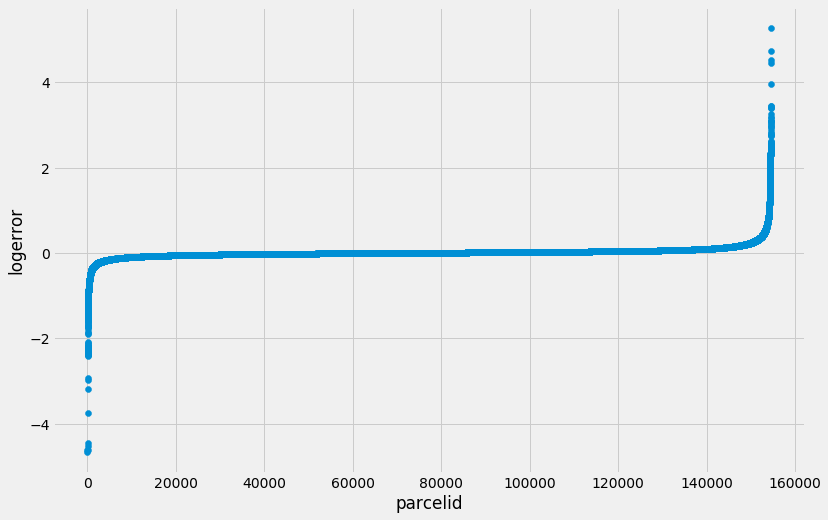

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


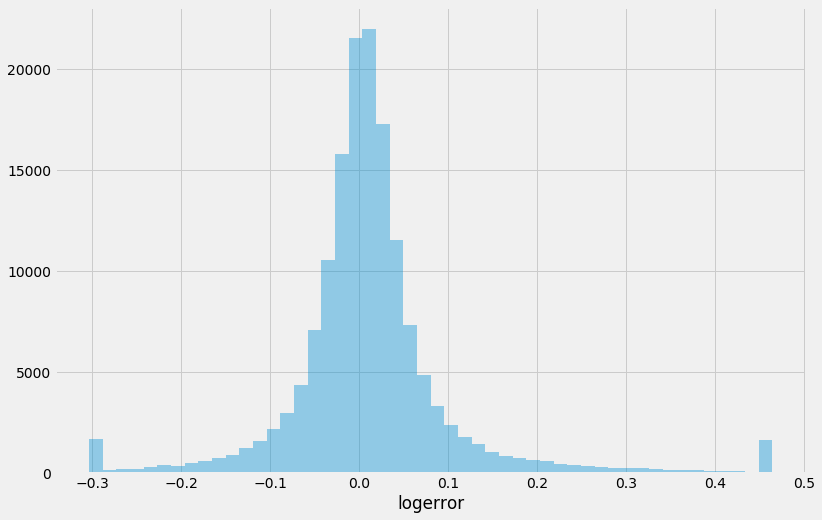

In [24]:
# Plot the log error
plt.figure(figsize=(12,8))
plt.scatter(range(df.shape[0]), np.sort(df.logerror.values))
plt.xlabel('parcelid')
plt.ylabel('logerror')
plt.show()

# Remove outliers
ulimit = np.percentile(df.logerror.values, 99)
llimit = np.percentile(df.logerror.values, 1)
df['logerror'].loc[df['logerror']>ulimit] = ulimit
df['logerror'].loc[df['logerror']<llimit] = llimit

# Plot the distribution
plt.figure(figsize=(12,8))
sns.distplot(df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror')
plt.show()

In [25]:
df.columns

Index(['logerror', 'transactiondate', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcounty', 'regionidzip', 'yearbuilt',
       'landtaxvaluedollarcnt', 'taxamount', 'propertylandusedesc',
       'heatingorsystemdesc'],
      dtype='object')

Let's create a variable to hold a list of numerical variables.

In [26]:
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols

['logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'yearbuilt',
 'landtaxvaluedollarcnt',
 'taxamount']

Let's create a variable to hold a list of non-numerical variables.

In [27]:
cat_cols = df.select_dtypes(exclude='number').columns.tolist()
cat_cols

['transactiondate',
 'buildingqualitytypeid',
 'regionidcounty',
 'regionidzip',
 'propertylandusedesc',
 'heatingorsystemdesc']

Let's use minmax scaling to standardize applicable variables.

In [28]:
df = dd.standardize_data(df, columns=['logerror',
                                      'bathroomcnt',
                                      'bedroomcnt',
                                      'calculatedbathnbr',
                                      'calculatedfinishedsquarefeet',
                                      'latitude',
                                      'longitude',
                                      'lotsizesquarefeet',
                                      'yearbuilt',
                                      'landtaxvaluedollarcnt',
                                      'taxamount'])

Let's see the distribution of some variables.

In [29]:
# dd.plot_hist(df)

Let's now generate a pairplot to see how our variables interact with each other.

In [30]:
# sns.pairplot(df, vars=num_cols)

And a heatmap to see the correlation of variables.

In [31]:
# df_heat = df[num_cols]
# dd.plot_heat(df_heat)

Let's remove redundant variables some more.

In [32]:
df = dd.remove_columns(df, cols_to_remove=['calculatedbathnbr',
                                           'fullbathcnt',
                                           'landtaxvaluedollarcnt'])
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols

['logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'yearbuilt',
 'taxamount']

Let's concentrate on single-unit dwellings...

In [33]:
df.propertylandusedesc.value_counts()

Single Family Residential                     108320
Condominium                                    41079
Planned Unit Development                        4132
Cluster Home                                     691
Mobile Home                                      126
Cooperative                                       57
Duplex (2 Units, Any Combination)                 50
Manufactured, Modular, Prefabricated Homes        37
Residential General                               29
Townhouse                                         17
Triplex (3 Units, Any Combination)                 6
Name: propertylandusedesc, dtype: int64

and narrow them down accordingly:

In [34]:
df = df.loc[(df['propertylandusedesc'] == 'Single Family Residential') |
                (df['propertylandusedesc'] == 'Condominium') |
                (df['propertylandusedesc'] == 'Residential General') |
                (df['propertylandusedesc'] == 'Townhouse')
               ]



In [35]:
df.propertylandusedesc.value_counts()

Single Family Residential    108320
Condominium                   41079
Residential General              29
Townhouse                        17
Name: propertylandusedesc, dtype: int64

In [36]:
# dd.summarize_data(df)

In [37]:
# dd.plot_rel(df, 'longitude', 'latitude', 'heatingorsystemdesc')

In [38]:
# dd.plot_rel(df, 'longitude', 'latitude', 'propertylandusedesc')

In [39]:
num_cols

['logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'yearbuilt',
 'taxamount']

In [40]:
df_xgb_x = df[num_cols].drop(columns=['logerror'])

In [41]:
fn = df_xgb_x.columns.values

/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


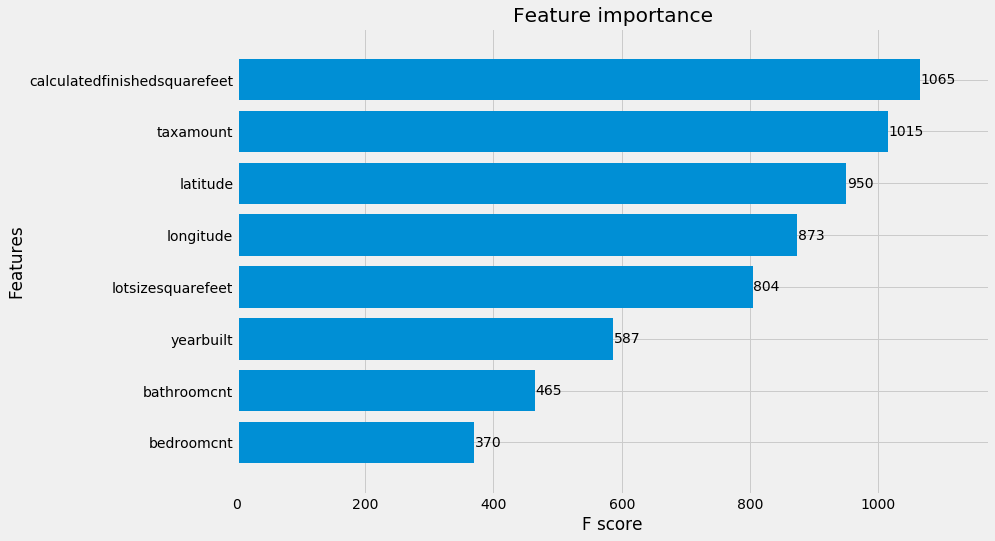

In [42]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(df_xgb_x, df.logerror, feature_names=fn)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Clustering

### Cluster 1 - logerror

In [43]:
df_c1 = df[['logerror']]

   k          sse
0  1  2350.482576
1  2  1230.856994
2  3   681.271219
3  4   413.486503
4  5   264.575020
5  6   180.658759
6  7   131.675666
7  8    98.267556
8  9    77.274900


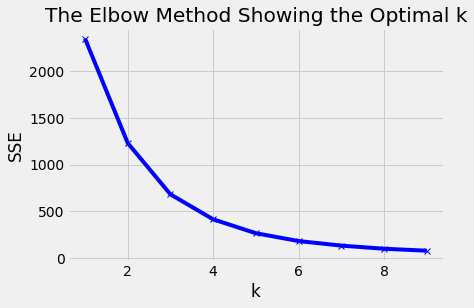

In [44]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_c1)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

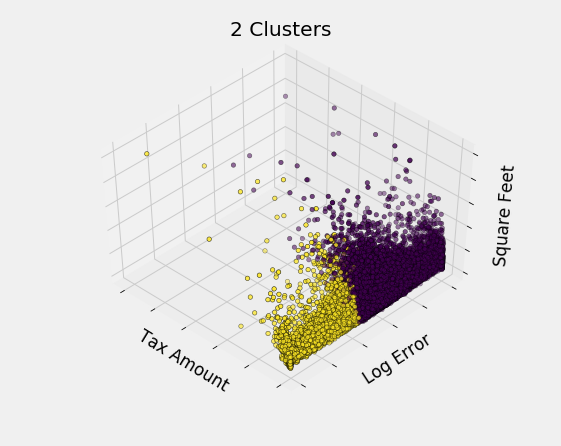

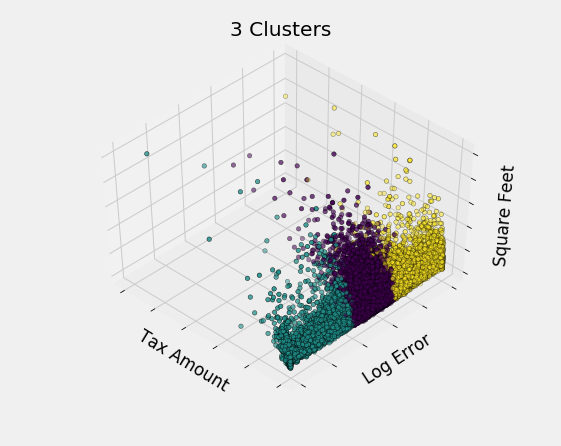

In [45]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

for i, (title, kmeans) in enumerate(estimators):
    # fit the kmeans object
    kmeans.fit(df_c1)

    fig = plt.figure(i + 1, figsize=(8, 6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = kmeans.labels_

    ax.scatter(df.taxamount, 
               df.logerror,
               df.calculatedfinishedsquarefeet,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Tax Amount')
    ax.set_ylabel('Log Error')
    ax.set_zlabel('Finished Sqft')
    ax.set_title(title)
    ax.dist = 12

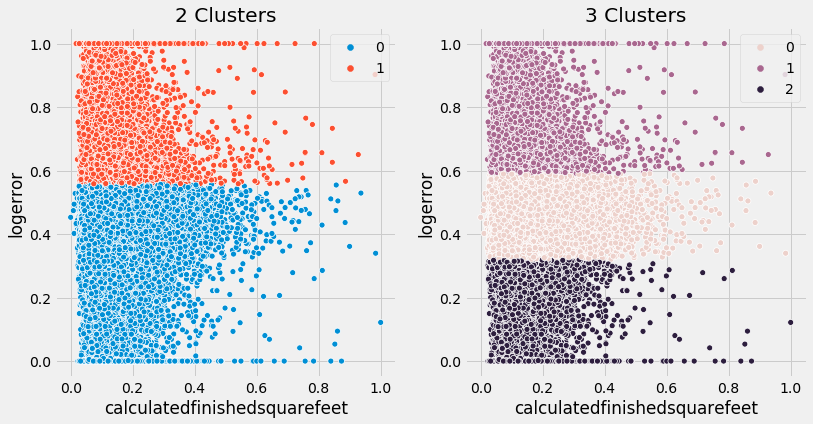

In [46]:
plt.subplots(nrows=1,ncols=2, figsize=(12,6))
for i, (title, kmeans) in enumerate(estimators):
    kmeans.fit(df_c1)
    labels = kmeans.labels_
    plot_number = i + 1 # i starts at 0, but plot numbers should start at 1
    plt.subplot(1, 2, plot_number)
    plt.title(title)
    sns.scatterplot(df.calculatedfinishedsquarefeet, df.logerror, hue=labels)

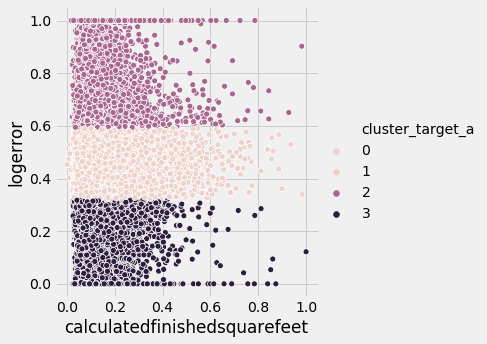

In [51]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_c1)
df['cluster_target_a'] = kmeans.predict(df_c1)
df.cluster_target_a = (df.cluster_target_a + 1)
sns.relplot(data=df, x='calculatedfinishedsquarefeet', y='logerror', hue='cluster_target_a')


In [53]:
df.cluster_target_a.value_counts()

1    122938
3     18330
2      8177
Name: cluster_target_a, dtype: int64

In [54]:
kmeans.cluster_centers_

array([[0.41478022],
       [0.76971338],
       [0.22767314]])

In [55]:
df.head()

,logerror,transactiondate,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcounty,regionidzip,yearbuilt,taxamount,propertylandusedesc,heatingorsystemdesc,cluster_target_a
0,0.431504,2016-01-01,0.10,0.272727,4.0,0.123713,0.592205,0.513791,0.019867,3101.0,96370.0,0.586957,0.020862,Single Family Residential,Central,1
1,0.176299,2016-01-01,0.25,0.363636,7.0,0.166299,0.127467,0.936005,0.017900,1286.0,96962.0,0.985507,0.031477,Single Family Residential,None,3
2,0.390359,2016-01-01,0.20,0.181818,4.0,0.162916,0.482496,0.677008,0.021838,3101.0,96293.0,0.449275,0.035613,Single Family Residential,Central,1
3,0.423952,2016-01-02,0.10,0.181818,4.0,0.061562,0.193954,0.607262,0.051922,3101.0,96222.0,0.789855,0.009409,Condominium,Central,1
5,0.043359,2016-01-02,0.30,0.363636,1.0,0.225434,0.280619,0.558444,0.017427,3101.0,96109.0,0.753623,0.084204,Single Family Residential,Central,3


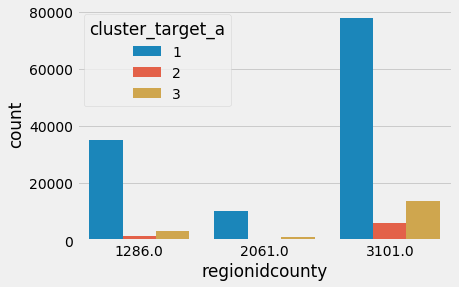

In [56]:
ax = sns.countplot(x="regionidcounty", hue="cluster_target_a", data=df, orient="h")

## Cluster 2 - calculatedfinishedsquarefeet

In [57]:
df_c2 = df[['calculatedfinishedsquarefeet']]

   k         sse
0  1  551.104361
1  2  223.911082
2  3  131.991036
3  4   83.520346
4  5   56.200080
5  6   41.443639
6  7   31.254953
7  8   24.458060
8  9   19.493245


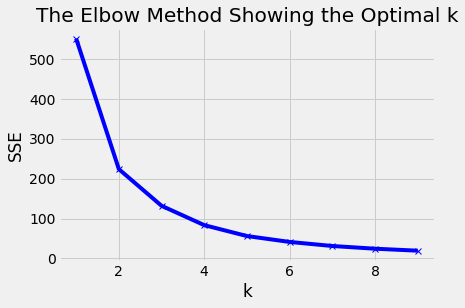

In [58]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_c2)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

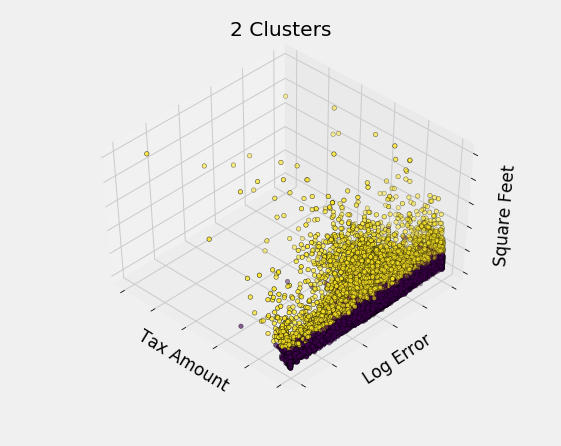

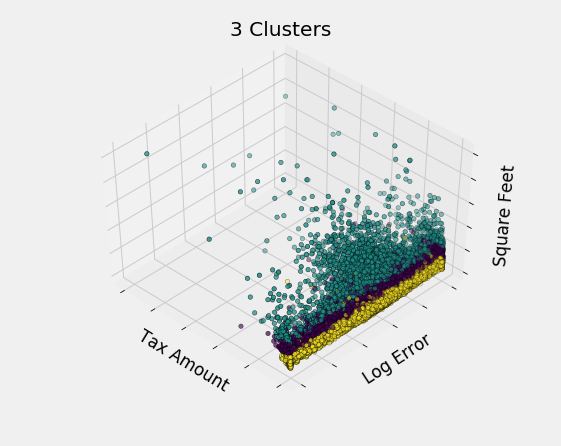

In [59]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3))]

for i, (title, kmeans) in enumerate(estimators):
    # fit the kmeans object
    kmeans.fit(df_c2)

    fig = plt.figure(i + 1, figsize=(8, 6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = kmeans.labels_

    ax.scatter(df.taxamount, 
               df.logerror,
               df.calculatedfinishedsquarefeet,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Tax Amount')
    ax.set_ylabel('Log Error')
    ax.set_zlabel('Finished Sqft')
    ax.set_title(title)
    ax.dist = 12

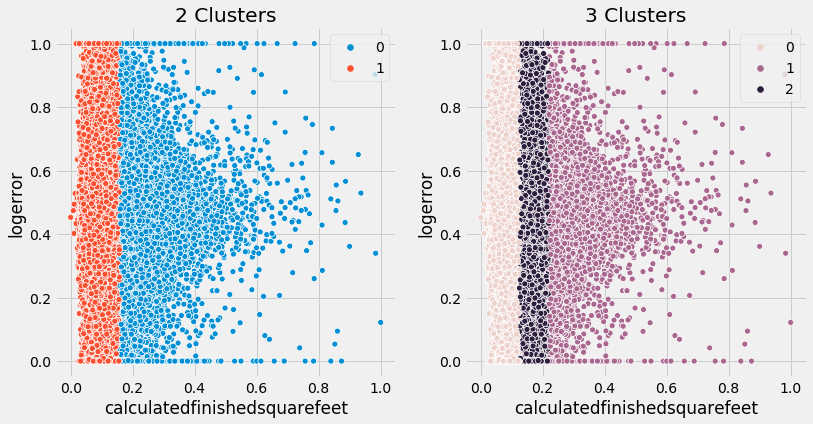

In [60]:
plt.subplots(nrows=1,ncols=2, figsize=(12,6))
for i, (title, kmeans) in enumerate(estimators):
    kmeans.fit(df_c2)
    labels = kmeans.labels_
    plot_number = i + 1 # i starts at 0, but plot numbers should start at 1
    plt.subplot(1, 2, plot_number)
    plt.title(title)
    sns.scatterplot(df.calculatedfinishedsquarefeet, df.logerror, hue=labels)

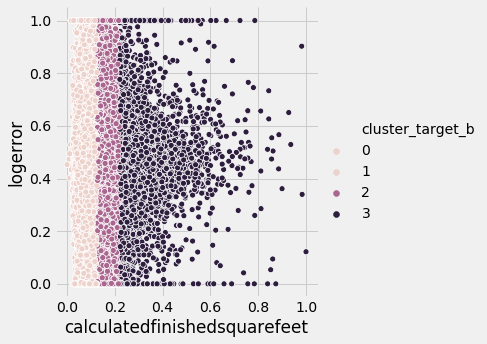

In [61]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_c2)
df['cluster_target_b'] = kmeans.predict(df_c2)
df.cluster_target_b = (df.cluster_target_b + 1)
sns.relplot(data=df, x='calculatedfinishedsquarefeet', y='logerror', hue='cluster_target_b')


In [62]:
kmeans.cluster_centers_

array([[0.0895267 ],
       [0.15930841],
       [0.28104466]])

In [63]:
df.head()

,logerror,transactiondate,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcounty,regionidzip,yearbuilt,taxamount,propertylandusedesc,heatingorsystemdesc,cluster_target_a,cluster_target_b
0,0.431504,2016-01-01,0.10,0.272727,4.0,0.123713,0.592205,0.513791,0.019867,3101.0,96370.0,0.586957,0.020862,Single Family Residential,Central,1,1
1,0.176299,2016-01-01,0.25,0.363636,7.0,0.166299,0.127467,0.936005,0.017900,1286.0,96962.0,0.985507,0.031477,Single Family Residential,None,3,2
2,0.390359,2016-01-01,0.20,0.181818,4.0,0.162916,0.482496,0.677008,0.021838,3101.0,96293.0,0.449275,0.035613,Single Family Residential,Central,1,2
3,0.423952,2016-01-02,0.10,0.181818,4.0,0.061562,0.193954,0.607262,0.051922,3101.0,96222.0,0.789855,0.009409,Condominium,Central,1,1
5,0.043359,2016-01-02,0.30,0.363636,1.0,0.225434,0.280619,0.558444,0.017427,3101.0,96109.0,0.753623,0.084204,Single Family Residential,Central,3,3


### Cluster 3 - lotsizesquarefeet

In [65]:
df_c3 = df[['lotsizesquarefeet']]

   k         sse
0  1  278.210834
1  2   98.726545
2  3   51.826285
3  4   30.560088
4  5   19.151813
5  6   12.538780
6  7    8.655721
7  8    6.340828
8  9    5.053242


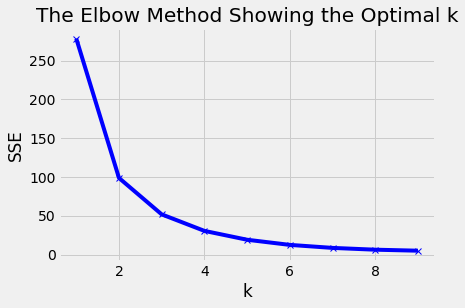

In [66]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_c3)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method Showing the Optimal k')
plt.show()

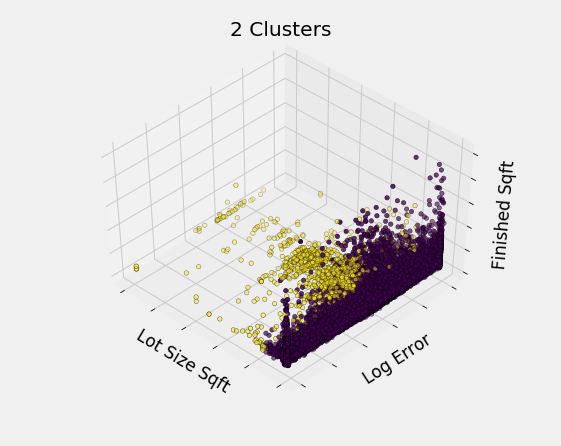

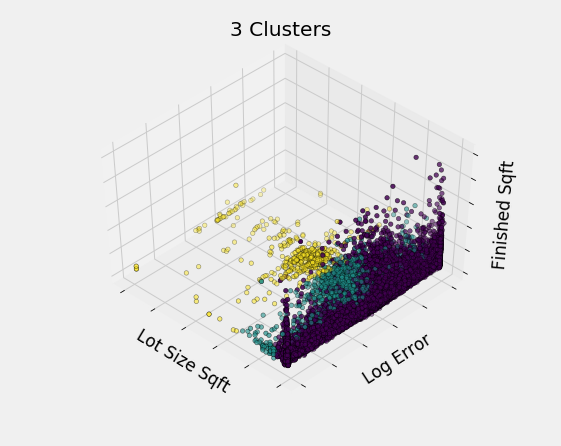

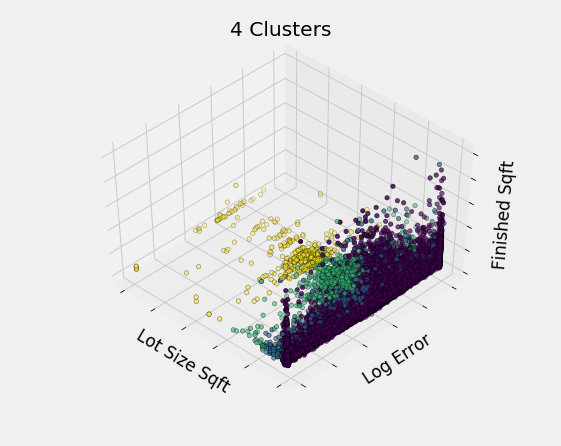

In [68]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('3 Clusters', KMeans(n_clusters=3)),
              ('4 Clusters', KMeans(n_clusters=4))]

for i, (title, kmeans) in enumerate(estimators):
    # fit the kmeans object
    kmeans.fit(df_c3)

    fig = plt.figure(i + 1, figsize=(8, 6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = kmeans.labels_

    ax.scatter(df.lotsizesquarefeet, 
               df.logerror,
               df.calculatedfinishedsquarefeet,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Lot Size Sqft')
    ax.set_ylabel('Log Error')
    ax.set_zlabel('Finished Sqft')
    ax.set_title(title)
    ax.dist = 12

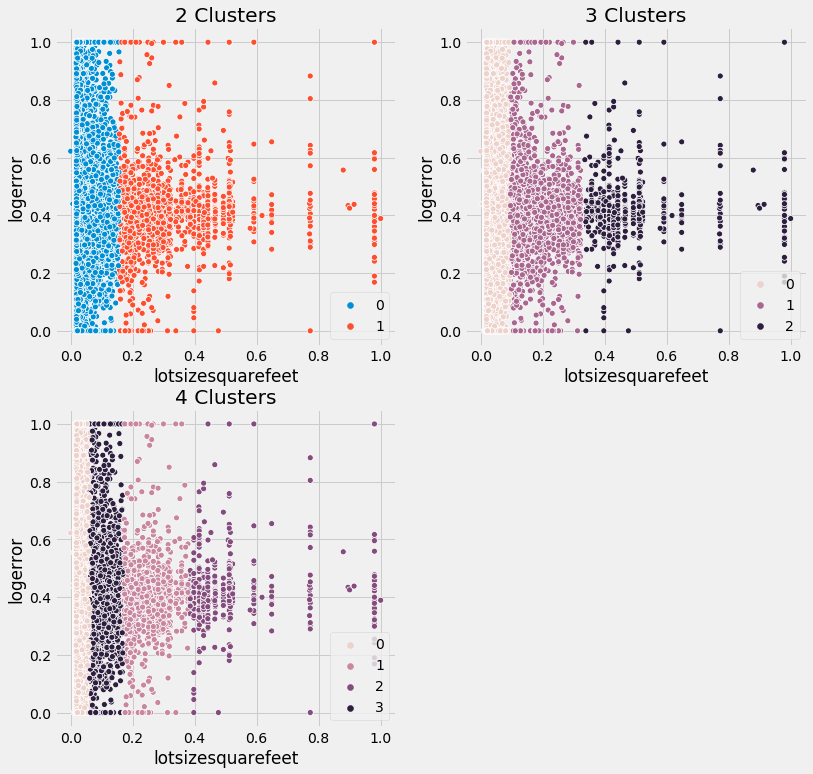

In [71]:
plt.subplots(nrows=1,ncols=2, figsize=(12,12))
for i, (title, kmeans) in enumerate(estimators):
    kmeans.fit(df_c3)
    labels = kmeans.labels_
    plot_number = i + 1 # i starts at 0, but plot numbers should start at 1
    plt.subplot(2, 2, plot_number)
    plt.title(title)
    sns.scatterplot(df.lotsizesquarefeet, df.logerror, hue=labels)

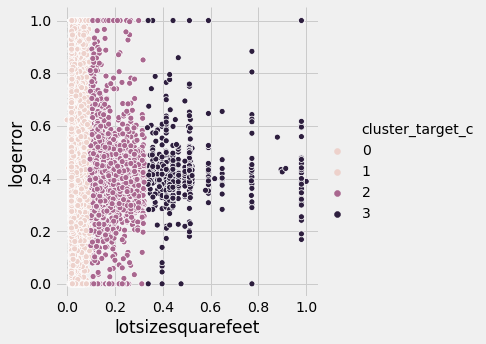

In [72]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_c3)
df['cluster_target_c'] = kmeans.predict(df_c3)
df.cluster_target_c = (df.cluster_target_c + 1)
sns.relplot(data=df, x='lotsizesquarefeet', y='logerror', hue='cluster_target_c')


In [73]:
kmeans.cluster_centers_

array([[0.02425134],
       [0.16547367],
       [0.50450305]])

In [74]:
df.head()

,logerror,transactiondate,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcounty,regionidzip,yearbuilt,taxamount,propertylandusedesc,heatingorsystemdesc,cluster_target_a,cluster_target_b,cluster_target_c
0,0.431504,2016-01-01,0.10,0.272727,4.0,0.123713,0.592205,0.513791,0.019867,3101.0,96370.0,0.586957,0.020862,Single Family Residential,Central,1,1,1
1,0.176299,2016-01-01,0.25,0.363636,7.0,0.166299,0.127467,0.936005,0.017900,1286.0,96962.0,0.985507,0.031477,Single Family Residential,None,3,2,1
2,0.390359,2016-01-01,0.20,0.181818,4.0,0.162916,0.482496,0.677008,0.021838,3101.0,96293.0,0.449275,0.035613,Single Family Residential,Central,1,2,1
3,0.423952,2016-01-02,0.10,0.181818,4.0,0.061562,0.193954,0.607262,0.051922,3101.0,96222.0,0.789855,0.009409,Condominium,Central,1,1,1
5,0.043359,2016-01-02,0.30,0.363636,1.0,0.225434,0.280619,0.558444,0.017427,3101.0,96109.0,0.753623,0.084204,Single Family Residential,Central,3,3,1


### Test the Significance of Clusters

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149445 entries, 0 to 167887
Data columns (total 18 columns):
logerror                        149445 non-null float64
transactiondate                 149445 non-null object
bathroomcnt                     149445 non-null float64
bedroomcnt                      149445 non-null float64
buildingqualitytypeid           149445 non-null object
calculatedfinishedsquarefeet    149445 non-null float64
latitude                        149445 non-null float64
longitude                       149445 non-null float64
lotsizesquarefeet               149445 non-null float64
regionidcounty                  149445 non-null object
regionidzip                     149445 non-null object
yearbuilt                       149445 non-null float64
taxamount                       149445 non-null float64
propertylandusedesc             149445 non-null object
heatingorsystemdesc             149445 non-null object
cluster_target_a                149445 non-null int64
c

In [77]:
ct_j = df[df['cluster_target_b'] == 1]
ct_k = df[df['cluster_target_b'] == 2]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: -9.119419696830905
p-value: 7.649321607984272e-20


In [78]:
ct_j = df[df['cluster_target_b'] == 2]
ct_k = df[df['cluster_target_b'] == 3]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: -11.369204700926238
p-value: 6.413881579695133e-30


In [79]:
ct_j = df[df['cluster_target_c'] == 1]
ct_k = df[df['cluster_target_c'] == 2]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: 1.5672430775540798
p-value: 0.11706001039983452


In [80]:
ct_j = df[df['cluster_target_c'] == 2]
ct_k = df[df['cluster_target_c'] == 3]

stat, p = stats.ttest_ind(ct_j['logerror'], ct_k['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: -4.075006588891268
p-value: 4.6651989628332316e-05


# Modeling

## Feature Engineering

### Remove variables that are not needed, wanted, or redundant.

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149445 entries, 0 to 167887
Data columns (total 18 columns):
logerror                        149445 non-null float64
transactiondate                 149445 non-null object
bathroomcnt                     149445 non-null float64
bedroomcnt                      149445 non-null float64
buildingqualitytypeid           149445 non-null object
calculatedfinishedsquarefeet    149445 non-null float64
latitude                        149445 non-null float64
longitude                       149445 non-null float64
lotsizesquarefeet               149445 non-null float64
regionidcounty                  149445 non-null object
regionidzip                     149445 non-null object
yearbuilt                       149445 non-null float64
taxamount                       149445 non-null float64
propertylandusedesc             149445 non-null object
heatingorsystemdesc             149445 non-null object
cluster_target_a                149445 non-null int64
c

In [82]:
df = dd.remove_columns(df, cols_to_remove=['transactiondate'])

In [84]:
df_bbroom = df
df_bbroom['bbroom'] = df.bathroomcnt + df.bedroomcnt
df_bbroom.drop(columns=['bathroomcnt', 'bedroomcnt'])

,logerror,buildingqualitytypeid,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcounty,regionidzip,yearbuilt,taxamount,propertylandusedesc,heatingorsystemdesc,cluster_target_a,cluster_target_b,cluster_target_c,bbroom
0,0.431504,4.0,0.123713,0.592205,0.513791,0.019867,3101.0,96370.0,0.586957,0.020862,Single Family Residential,Central,1,1,1,0.372727
1,0.176299,7.0,0.166299,0.127467,0.936005,0.017900,1286.0,96962.0,0.985507,0.031477,Single Family Residential,None,3,2,1,0.613636
2,0.390359,4.0,0.162916,0.482496,0.677008,0.021838,3101.0,96293.0,0.449275,0.035613,Single Family Residential,Central,1,2,1,0.381818
3,0.423952,4.0,0.061562,0.193954,0.607262,0.051922,3101.0,96222.0,0.789855,0.009409,Condominium,Central,1,1,1,0.281818
5,0.043359,1.0,0.225434,0.280619,0.558444,0.017427,3101.0,96109.0,0.753623,0.084204,Single Family Residential,Central,3,3,1,0.663636
6,0.452858,7.0,0.095249,0.302903,0.657387,0.019436,3101.0,96091.0,0.442029,0.007098,Single Family Residential,Floor/Wall,1,1,1,0.181818
7,0.608845,7.0,0.129523,0.536253,0.161303,0.031545,2061.0,97101.0,0.840580,0.011573,Condominium,None,2,2,1,0.422727
8,0.391661,7.0,0.058400,0.037593,0.935774,0.031840,1286.0,96987.0,0.768116,0.006688,Condominium,None,1,1,1,0.181818
9,0.505331,7.0,0.092527,0.085442,0.902454,0.032170,1286.0,96963.0,0.717391,0.005965,Condominium,None,1,1,1,0.281818
10,0.893606,7.0,0.104075,0.504000,0.519279,0.020247,3101.0,96426.0,0.550725,0.004423,Single Family Residential,Central,2,1,1,0.281818


In [ ]:
df.head()

### Train and Test Split

In [ ]:
# train_test_split
X = df.drop(['logerror'], axis=1)

print(X.head())

y = df[['logerror']]
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=493)

train = pd.concat([X_train, y_train], axis=1)

print()
print("Train columns:  %s" % list(train.columns))
print("Train dimensions (rows, columns):", train.shape)
print()

test = pd.concat([X_test, y_test], axis=1)

print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)
print()

X.sample(10)